In [1]:
import pandas as pd 
import gensim
import pandas as pd
import numpy as np
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from gensim import corpora, models

In [3]:
df_train = pd.read_csv("../data_source/datagrand_2021_train.csv")
df_test = pd.read_csv("../data_source/datagrand_2021_test.csv")
label = df_train['label'].values
df = pd.concat([df_train, df_test], ignore_index=True)

In [4]:
df.head(5)

,id,text,label
0,0,7442 27878 9601 235 4004 10636 19121 28648 227...,5-30
1,1,2281 24058 20163 22737 25572 1845 10446 28438 ...,5-30
2,2,12163 8224 13343 26307 18947 10922 10446 8679 ...,1-1
3,3,28685 16037 3261 14485 26363 16037 29555 8766 ...,1-9
4,4,10974 16249 8266 16328 2103 4198 929 4685 2254...,1-9


In [25]:
df_train['label'].value_counts()

1-9      1931
5-30     1289
1-1      1092
2-3       986
2-6       815
1-4       799
2-2       736
6-15      638
4-7       624
1-10      622
2-33      591
5-35      377
2-11      358
6-29      323
6-8       293
2-14      281
5-22      247
2-25      239
6-28      223
5-12      205
6-13      185
6-19      178
2-17      176
6-34      159
6-31      156
6-21      134
6-32      103
5-24       62
8-27       49
6-20       33
7-16       32
8-18       20
9-23       19
10-26      18
3-5        16
Name: label, dtype: int64

In [5]:
train_list = []
for i in range(len(df)):
    train_list.append(df['text'][i].split(' '))

In [49]:
# label 转化为 label_id
label_id_map = {}
id_label_map = {}
k = 0
for e in sorted(set(label)):
    label_id_map[e] = k 
    id_label_map[k] = e
    k += 1
print("总类别数:", len(label_id_map), len(id_label_map))

总类别数: 35 35


In [7]:
label_id = df_train['label'].apply(lambda x: label_id_map[x])

In [8]:
dic = corpora.Dictionary(train_list)
len(dic)

3456

In [34]:
# len(set(train_list[3])), dic.doc2bow(train_list[10])

In [9]:
new_corpus = [dic.doc2bow(words) for words in train_list]

In [10]:
tfidf = models.TfidfModel(new_corpus)

In [42]:
matrix = np.zeros((len(train_list), len(dic)))
for i in range(len(train_list)):
    string_bow = dic.doc2bow(train_list[i])
#     print(string_bow)
    string_dic = tfidf[string_bow]
    for e in string_dic:
        matrix[i][e[0]] = e[1]

In [43]:
matrix[0]
matrix_sparse = coo_matrix(matrix)

In [13]:
svd_feature = TruncatedSVD(n_components=100).fit_transform(matrix_sparse)
train_df = svd_feature[:-len(df_test)]
test_df = svd_feature[-len(df_test):]

In [14]:
train_X, test_X, train_Y, test_Y = train_test_split(train_df, label_id, \
                                test_size=0.2, random_state=2021, stratify=label_id)

In [15]:
len(train_X), len(test_X)

(11207, 2802)

In [16]:
print("训练数据：测试数据=", len(train_X), len(train_Y))

训练数据：测试数据= 11207 11207


In [17]:
train_data = lgb.Dataset(train_X, label=train_Y)
valid_data = lgb.Dataset(test_X, label=test_Y)

In [18]:
params = {'num_leaves': 40, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
#           'objective': 'binary', #定义的目标函数
          "objective":'multiclass',
          'max_depth': -1,
          'learning_rate': 0.3,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.5,				#l1正则
          'lambda_l2': 0.5,		#l2正则
          "verbosity": -1,
          "nthread": -1,				#线程数量，-1表示全部线程，线程越多，运行的速度越快
          "num_class": 35, 
          "metric":'multi_error',
#           "metric":{'auc_mu'},
#           'metric':{'auc', 'f1'},
#           'metric':{'acc'},
#           'metric': {'binary_logloss', 'auc'},	##评价函数选择
          "random_state": 2020,	#随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

In [19]:
evals_result = {} ## 记录结果所用
clf=lgb.train(params,
              train_data,
              valid_sets=[train_data, valid_data],
              evals_result = evals_result
             )



[1]	training's multi_error: 0.617739	valid_1's multi_error: 0.661313
[2]	training's multi_error: 0.523244	valid_1's multi_error: 0.60778
[3]	training's multi_error: 0.45079	valid_1's multi_error: 0.583155
[4]	training's multi_error: 0.396002	valid_1's multi_error: 0.562455
[5]	training's multi_error: 0.351031	valid_1's multi_error: 0.552106
[6]	training's multi_error: 0.307129	valid_1's multi_error: 0.547466
[7]	training's multi_error: 0.275631	valid_1's multi_error: 0.534618
[8]	training's multi_error: 0.245293	valid_1's multi_error: 0.528551
[9]	training's multi_error: 0.220487	valid_1's multi_error: 0.519986
[10]	training's multi_error: 0.191487	valid_1's multi_error: 0.519272
[11]	training's multi_error: 0.170429	valid_1's multi_error: 0.517131
[12]	training's multi_error: 0.152851	valid_1's multi_error: 0.512491
[13]	training's multi_error: 0.13438	valid_1's multi_error: 0.507495
[14]	training's multi_error: 0.118497	valid_1's multi_error: 0.509993
[15]	training's multi_error: 0.1

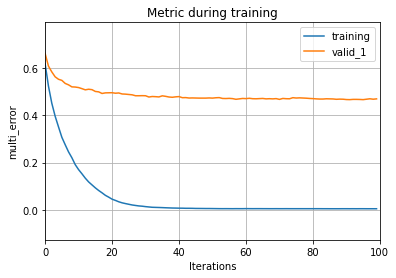

In [20]:
ax = lgb.plot_metric(evals_result)

In [44]:
y_pred=clf.predict(test_df)

In [54]:
results= []
for i in range(len(y_pred)):
    results.append(id_label_map[np.argmax(y_pred[i])])

### 2. 提交结果整理

In [55]:
# 样例
sample = pd.read_csv("../data_source/sample_submission.csv")

In [56]:
sample.head(5)

,id,label
0,0,2-14
1,1,2-17
2,2,5-12
3,3,5-35
4,4,1-1


In [59]:
myresult = {"id":list(df_test['id'].values), "label":results}

In [63]:
pd.DataFrame(myresult).to_csv("results/myresult.csv", index=False)